In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler
import gseapy as gp
import statsmodels.api as sm
from adjustText import adjust_text

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
GS_FILE=DATA_PATH+'/gs_file/magma_10kb_1000.gs'
TRAIT_INFO_FILE=DATA_PATH+'/supp_table/trait_info.tsv'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_tcell'

# Set data info
# DS_LIST = ['facs', 'droplet', 'canogamez']
DS_LIST = ['facs']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['droplet'] = {'species': 'mmusculus', 'dname': 'TMS Droplet'}
DIC_INFO['canogamez'] = {'species': 'hsapiens', 'dname': 'Human CD4 T cells'}

# Set score file
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000',
#                   'droplet': DATA_PATH+'/score_file/score.tms_droplet_with_cov.magma_10kb_1000',
#                   'canogamez': DATA_PATH+'/score_file/score.canogamez_with_cov.magma_10kb_1000',
                  'facs_tsig': DATA_PATH+'/score_file/score.tms_facs_with_cov.tcell_sig',
#                   'droplet_tsig': DATA_PATH+'/score_file/score.tms_droplet_with_cov.tcell_sig'
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['facs'] = ['PASS_IBD_deLange2017',
                          'PASS_CD_deLange2017', 
                          'PASS_UC_deLange2017',
                          'UKB_460K.disease_AID_ALL', 
                          'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
                          'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED',
                          'UKB_460K.disease_ASTHMA_DIAGNOSED', 
                          'PASS_Rheumatoid_Arthritis',
                          'UKB_460K.disease_RESPIRATORY_ENT',
                          'UKB_460K.body_HEIGHTz', 'UKB_460K.biochemistry_Triglycerides']
DIC_TRAIT_LIST['facs_tsig'] = ['naive_cd4', 'memory_cd4', 'effector_cd4', 'reg_cd4', 
                               'naive_cd8', 'memory_cd8', 'effector_cd8']

# Set trait info
DF_TRAIT_INFO = pd.read_csv(TRAIT_INFO_FILE, sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
temp_dic = {'naive_cd4':'Naive CD4', 'memory_cd4':'Memory CD4', 'effector_cd4':'Effector CD4', 'reg_cd4':'Treg',
            'naive_cd8':'Naive CD8', 'memory_cd8':'Memory CD8', 'effector_cd8':'Effector CD8'}
for trait in temp_dic:
    DF_TRAIT_INFO.loc[trait, ['Trait_Identifier', 'Code']] = [trait, temp_dic[trait]]
for trait in DF_TRAIT_INFO.index[DF_TRAIT_INFO['Code'].isna()]:
    trait_short = trait.replace('PASS_','').replace('UKB_460K.','')
    trait_short = trait_short.replace('blood_','').replace('disease_','')
    DF_TRAIT_INFO.loc[trait, 'Code'] = trait_short

### Load data 

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
# dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')
# dic_data_raw['canogamez'] = dl.load_canogamez_raw_data()

dic_data_proc = {}
dic_data_proc['facs'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                                  'tcell.facs.annot.h5ad')
# dic_data_proc['canogamez'] = dl.load_canogamez_raw_data(opt='processed')

Trying to set attribute `.obs` of view, copying.


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for score in DIC_SCORE_PATH:
    ds = score.replace('_tsig','')
    dic_cell_list[score] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[score].index))

In [5]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.full_score.gz'%trait)
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df = temp_df.loc[set(dic_data_proc['facs'].obs_names) & set(temp_df.index)]
            dic_ctrl_score[score][trait] = temp_df.copy()
        else:
            print('# missing: %s'%file_path)
        dic_ctrl_score[score][trait] = dic_ctrl_score[score][trait].loc[dic_cell_list[score]].copy()

# Loading facs PASS_IBD_deLange2017
# Loading facs PASS_CD_deLange2017
# Loading facs PASS_UC_deLange2017
# Loading facs UKB_460K.disease_AID_ALL
# Loading facs UKB_460K.disease_HYPOTHYROIDISM_SELF_REP
# Loading facs UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED
# Loading facs UKB_460K.disease_ASTHMA_DIAGNOSED
# Loading facs PASS_Rheumatoid_Arthritis
# Loading facs UKB_460K.disease_RESPIRATORY_ENT
# Loading facs UKB_460K.body_HEIGHTz
# Loading facs UKB_460K.biochemistry_Triglycerides
# Loading facs_tsig naive_cd4
# Loading facs_tsig memory_cd4
# Loading facs_tsig effector_cd4
# Loading facs_tsig reg_cd4
# Loading facs_tsig naive_cd8
# Loading facs_tsig memory_cd8
# Loading facs_tsig effector_cd8


### UMAP for all T cells 

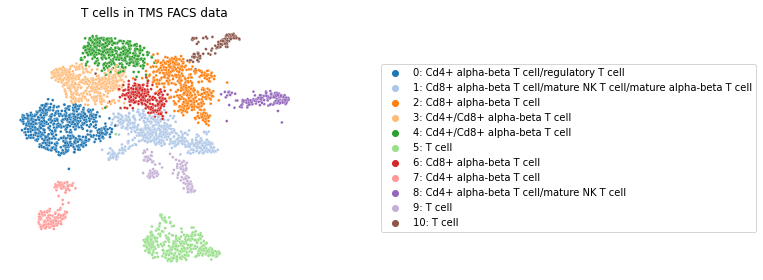

In [6]:
# Figure 
df_plot = pd.DataFrame(index=dic_data_proc['facs'].obs_names,
                       data={'UMAP1':dic_data_proc['facs'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc['facs'].obsm['X_umap'][:,1]}, dtype=float)
df_plot = df_plot.join(dic_data_proc['facs'].obs[['leiden_fil', 'leiden_anno']])
df_plot['label'] = ['%s: %s'%(x,y) for x,y in zip(df_plot['leiden_fil'], df_plot['leiden_anno'])]
df_plot['label'] = df_plot['label'].astype('category')

hue_list = []
for x in df_plot['leiden_fil'].cat.categories:
    for y in set(df_plot['label']):
        if y.startswith('%s: '%x):
            hue_list.append(y)

plt.figure(figsize=[12,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='label', s=8, palette='tab20', hue_order=hue_list)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('T cells in TMS FACS data')
plt.tight_layout()
plt.savefig(FIG_PATH+'/tcell_tms_annot_umap.svg')
plt.savefig(FIG_PATH+'/tcell_tms_annot_umap.png')
plt.show()

### Subpolulation of associated cells 

In [ ]:
# ds = 'facs'
# for trait in DIC_TRAIT_LIST[ds]:
        
#     plt.figure(figsize=[5,4])
#     ax = plt.subplot(1,1,1)
#     ax.axis('off')
#     df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
#                            data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
#                                  'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
#                                  'leiden_anno':dic_data_proc[ds].obs['leiden_anno']})
#     df_plot = df_plot.loc[dic_cell_list[ds]]
#     df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
#     df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

#     ind_select = df_plot['%s.fdr'%trait]<0.1
#     vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
#     vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
#     plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
#                 c='k', s=4, alpha=0.025)
#     plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
#                 c=df_plot.loc[ind_select, '%s.norm_score'%trait],
#                 cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
#     plt.colorbar()
#     plt.title('scDRS z-score for %s'%DF_TRAIT_INFO.loc[trait, 'Code'])

#     plt.tight_layout()
#     plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
#     plt.show()

### Annotation for PASS_IBD_deLange2017 associated cells 

In [ ]:
trait = 'PASS_IBD_deLange2017'
ds = 'facs'

# Assign sig label for each leiden cluster (remove sig cells in small clusters)
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm

adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['leiden_sig'] = ['%s.sig'%x if y<0.1 else 'nonsig'
                           for x,y in zip(adata.obs['leiden_fil'], adata.obs['%s.fdr'%trait])]

temp_df = adata.obs.groupby(['leiden_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<25])
adata.obs.loc[adata.obs['leiden_sig'].isin(cluster_remove_list), 'leiden_sig'] = 'nonsig' 

# Summarize significant cells in each cluster
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
for group in group_list:
    print('# cluster %s: %d/%d significant (%d nonsig)'
          %(group.split('.')[0], (adata.obs['leiden_sig']==group).sum(), 
            (adata.obs['leiden_fil']==group.split('.')[0]).sum(), 
            (adata.obs['leiden_fil']==group.split('.')[0]).sum() - (adata.obs['leiden_sig']==group).sum()))
    temp_df = adata.obs.loc[adata.obs['leiden_sig']==group].copy()
    temp_df = temp_df.groupby('cell_ontology_class').agg({'cell':len})
    temp_df = temp_df.loc[temp_df['cell']>0]
    display(temp_df)

# Specifically expressed genes 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
sc.tl.rank_genes_groups(adata, groupby='leiden_sig', groups=group_list, method='wilcoxon')
# sc.tl.rank_genes_groups(adata, groupby='leiden_sig', reference='nonsig', groups=group_list)
sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

# Marker gene expression 
marker_list = ['Cd3d', 'Cd4', 'Cd8a', # Basic
               'Sell', 'Ccr7', 'Npm1', 'Cd44', # Naive Cd44-               
               'Cd69', 'Tfrc', 'Il2ra', 'Tnfrsf4', # Activation: Cd69, Cd71, Cd25 (also Treg)
               'Ctla4', 'Foxp3', # Treg
               'Gzmk', 'Gzmb', 'Gzma', 'Prf1', 'Ifng', 'Fasl', # Cd8+ cytotoxic T cells
               'Il7r', 'Tnfsf13b', 'Ccl4', 'Ccl5', # effector memory
               'Icos', 'Nfkbia', 'Nfkbiz', 'Klrg1', 'Pdcd1', # Others
              ]
sc.pl.dotplot(adata, marker_list, groupby='leiden_sig')

In [84]:
np.where(np.array([x[0] for x in adata.uns['rank_genes_groups']['names']])=='Foxp3')

KeyError: 'rank_genes_groups'

In [ ]:
# UMAP plot with annotations 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
dic_config = {'0.sig': ['0: Cd4+ alpha-beta T cell/regulatory T cell (Treg-like)'], 
              # Ctla4 (Treg), Nrp1 (Treg), Tnfrsf18 (Treg), Ikzf2 (helios, Treg), Tnfrsf4 (OX40, effector)
              '2.sig': ['2: Cd8+ alpha-beta T cell (effector-like Cd8+)'],
              # Fasl (CD8+ cytotoxic T), Ifng (CD8+ cytotoxic T), Ccl5 (HIV-suppressive factor)
              '5.sig': ['5: T cell (Th17-like)'], 
              # Cd4- Cd8-, may not be typical T cells
              '7.sig': ['7: Cd4+ alpha-beta T cell (Treg-like IL1RL1+ KLRG1+ AREG+)']
              # Li_CR_2019, effector Treg-like
             }
cmap = matplotlib.cm.get_cmap('tab20')

# Get df_plot 
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['leiden_fil', 'leiden_sig']])
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

# Figure 
plt.figure(figsize=[10.5,4])
ax = plt.subplot(1,1,1)
ax.axis('off')

# Cluster boundry 
x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
for cluster in ['0.sig', '2.sig', '5.sig', '7.sig']:
    ind_select = df_plot['leiden_fil']==cluster.split('.')[0]
    temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
    xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
    xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
    ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
    ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
    ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                    (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                s=16, color=cmap(int(cluster.split('.')[0])),
                label=dic_config[cluster][0], zorder=0)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=120, color=cmap(int(cluster.split('.')[0])), zorder=1)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=60, color='w', zorder=2)

ind_select_sig = (df_plot['leiden_sig']!='nonsig')
np.random.seed(0)
cell_list_nonsig = np.random.choice(df_plot.index[~ind_select_sig], 
                                    size=int((~ind_select_sig).sum()*0.2), replace=False)
plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)

vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
            c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
            cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
plt.colorbar()
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
plt.title('scDRS z-score for %s'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.tight_layout()
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_IBD_umap.svg')
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_IBD_umap.png')
plt.show()

In [ ]:
# Show interesting genes 
# https://www.rndsystems.com/resources/cell-markers/immune-cells/regulatory-t-cell/regulatory-t-cell-markers
gene_plot_list = ['Cd3d', 'Cd4', 'Cd8a', # T cell general
                  'Foxp3', 'Ctla4', 'Lag3', 'Ikzf2', 'Nrp1', 'Folr4', 'Tnfrsf4', 'Tnfrsf18', # Treg
                  # Foxp3: master regulator of regulatory pathway in development and function of Treg
                  # Ctla4: immune checkpoint and downregulates immune responses (T cell proliferation), 
                  # Lag3: Treg suppressive function
                  # Ikzf2 (Helios): hematopoietic-specific TF, regulation of lymphocyte development,
                      # Stable inhibitory activity of regulatory T cells requires the transcription factor Helios
                      # Kim et al Science 2015
                  # Nrp1 (Neuropilin-1): angiogenesis, axon guidance, cell survival, migration, and invasion, 
                  # Folr4 (Fr4): cell-surface marker of Tregs
                  # Tnfrsf4 (OX40): secondary co-stimulatory immune checkpoint molecule
                      # "A non‐redundant role for OX40 in the competitive fitness of Treg in response to IL‐2"
                      # Piconese EJI 2010
                  # Tnfrsf18 (Gitr): co-stimulatory immune checkpoint molecule, play a key role in dominant 
                      # immunological self-tolerance maintained by CD25+/CD4+ regulatory T cells        
                  'Il1rl1', 'Klrg1', 'Areg', 'Gata3', # KA Treg
                  # Il1rl1 (St2): enhance Treg functions 
                  # Klrg1: co-inhibitory immune checkpoint, Treg differentiation
                  # Areg: tissue repair. endogenous AREG with IL-33 decreased the intestinal inflammation in 
                      # mice with normal count of T-lymphocytes and in deficient mice
                  # Gata3: promote St2 by binding to an enhancer element Foxp3
                  'Ifng', 'Fasl', # CTL
                  # Igng: also produced by Cd8 T cells
                  # Fasl: Fas ligandl Its binding with its receptor induces apoptosis
                  # CTL
                  'Il1r1', 'Il23r', 'Rorc', 'Il17a', 'Il17f', # Th17
                  # Il1r1: Th17 differentiation
                  # Il23r: enhances Th17 differentiation
                  # Rorc (ROR gamma t): differentiation of Th17 cells
                  # Il17a/Il17f: inducing and mediating proinflammatory responses
                 ]
for gene in gene_plot_list.copy():
    if gene not in adata.var_names:
        print('# missing: %s'%gene)
        gene_plot_list.remove(gene)
adata.obs['leiden_sig_anno'] = ['%s.assoc'%(dic_config[x][0].split(':')[0]) 
                                if x in dic_config else 'others' for x in adata.obs['leiden_sig']]

# sc.pl.dotplot(adata, gene_plot_list, groupby='leiden_sig_anno', 
#               categories_order=['associated cells in cluster 0', 'associated cells in cluster 2',
#                                 'associated cells in cluster 5', 'associated cells in cluster 7', 'others'])
sc.pl.dotplot(adata, gene_plot_list, groupby='leiden_sig_anno', 
              categories_order=['0.assoc', '2.assoc',
                                '5.assoc', '7.assoc', 'others'], 
              save='sctrs_assoc.annot_IBD_umap_marker_gene.svg')

In [ ]:
# Over with signatures (need a better version)
temp_df = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/tcell_signature.gs', 
                      sep='\t', index_col=0)
df_sig = temp_df.loc[['effector_cd8']].copy()
for gs in df_sig.index:
    df_sig.loc[gs, 'GENESET'] = set([dic_map[x] for x in df_sig.loc[gs, 'GENESET'].split(',') if x in dic_map])
temp_df = pd.read_excel('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation'
                        '/Li_CR_2019_tabs2.xlsx', sheet_name='Treg Pagoda modules', skiprows=1)
df_sig.loc['KA_TR', 'GENESET'] = set(temp_df['Module 12']) | set(temp_df['Module 21']) - {np.nan}
# df_sig.loc['IFNstim_TR', 'GENESET'] = set(temp_df['Module 23']) | set(temp_df['Module 6']) - {np.nan}
df_sig.loc['Th17', 'GENESET'] = set(temp_df['Module 13']) - {np.nan}
# df_sig.loc['naive', 'GENESET'] = set(temp_df['Module 18']) - {np.nan}

background_set = set(adata.var_names)

df_stats = pd.DataFrame(index=df_sig.index, columns=group_list, data=0)
for sig in df_sig.index:
    gs_sig = df_sig.loc[sig, 'GENESET']
    for group in group_list:
        df_gene = sc.get.rank_genes_groups_df(adata, group=group)
        gs = set(df_gene['names'][:100])
        pvalue,oddsratio,or_ub,or_lb = util.test_overlap(gs, gs_sig, background_set)
        df_stats.loc[sig, group] = pvalue
        print('%s    %s    overlap=%d    p=%0.1e    %s'
              %(sig, group, len(gs & gs_sig), pvalue, ','.join(gs & gs_sig)))
        
display(df_stats)

In [ ]:
# Pathway: enrichr
dic_pathway = {}
group_list = list(adata.uns['rank_genes_groups']['names'].dtype.names)
pw_list = []
for group in group_list:
    df_gene = sc.get.rank_genes_groups_df(adata, group=group)
    gene_list = list(df_gene['names'][:100])

    res = gp.enrichr(gene_list=gene_list, description='pathway',
                         gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2018', 'Reactome_2016'],
                         organism='Mouse', outdir=None)
    df_pathway = res.results
    df_pathway = df_pathway.loc[df_pathway['Adjusted P-value']<0.01].copy()
    df_pathway['Intersect'] = [int(x.split('/')[0]) for x in df_pathway['Overlap']]
    df_pathway['Term_size'] = [int(x.split('/')[1]) for x in df_pathway['Overlap']]
    df_pathway['Recall'] = df_pathway['Intersect'] / df_pathway['Term_size']
    dic_pathway[group] = df_pathway.copy()
    ind_select = (df_pathway['Intersect']>15) | (df_pathway['Recall']>0.15)
    ind_select = ind_select & (df_pathway['Term_size']>5) & (df_pathway['Term_size']<500) 
    pw_list.extend(df_pathway.loc[ind_select, 'Term'])

for group in group_list:
    dic_pathway[group].index = dic_pathway[group]['Term']
    dic_pathway[group] = dic_pathway[group].loc[set(dic_pathway[group].index) & set(pw_list)]

In [ ]:
df_plot = pd.DataFrame()
dic_source = {'KEGG_2019_Mouse':'KEGG', 'GO_Biological_Process_2018':'GO:BP', 'Reactome_2016':'REAC'}
for group in group_list:
    temp_df = dic_pathway[group][['Adjusted P-value']]
    temp_df.index = ['%s:%s'%(dic_source[x],y.split(' (GO')[0].split(' Homo')[0]) 
                     for x,y in zip(dic_pathway[group]['Gene_set'], dic_pathway[group]['Term'])]
    temp_df.columns = [group]
    df_plot = df_plot.join(temp_df, how='outer')

df_plot.fillna(1, inplace=True)
df_plot = -np.log10(df_plot)
df_plot = df_plot[['0.sig', '7.sig', '5.sig', '2.sig']]
df_plot.index.name = ''
df_plot.columns = [dic_config[x][0].split(':')[0]+'.assoc' for x in df_plot.columns]

g = sns.clustermap(df_plot, metric='euclidean', col_cluster=False, 
               figsize=(10,10), cbar_pos=(0, 0.9, 0.05, 0.05),
               cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig(FIG_PATH+'/IBD_pathway.svg')
plt.show()

In [ ]:
# Compute genes driving each cluster 
df_gs_gwas = pd.read_csv(GS_FILE, sep='\t', index_col=0)
df_hom = pd.read_csv(DATA_PATH + '/gene_annotation/mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
gwas_gene_list = [dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map]
df_contrib = md.compute_gene_contrib(adata, gwas_gene_list)

df_contrib_stats = pd.DataFrame(index=df_contrib.columns, columns=group_list, data=0)
for group in group_list:
    cell_list = list(adata.obs_names[adata.obs['leiden_sig']==group])
    temp_df_sig = df_contrib.loc[cell_list].copy()
    temp_df_rest = df_contrib.loc[~df_contrib.index.isin(cell_list)]
    df_contrib_stats[group] = [sp.stats.ttest_ind(temp_df_sig[x].values, temp_df_rest[x].values)[0]
                               for x in df_contrib.columns]

In [ ]:
gene_list = []
for group in df_contrib_stats.columns:
    gene_list.extend(df_contrib_stats.sort_values(by=group, ascending=False).index[:10])
gene_list = list(set(gene_list))
df_plot = df_contrib_stats.loc[gene_list]
df_plot.values[df_plot.values<0] = 0
df_plot = df_plot[['0.sig', '7.sig', '2.sig', '5.sig']]
df_plot.columns = [dic_config[x][0].split(':')[0]+'.assoc' for x in df_plot.columns]

g = sns.clustermap(df_plot, metric='cosine', col_cluster=False, figsize=(4,10), 
               cbar_pos=(0, 0.8, 0.05, 0.05), cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig(FIG_PATH+'/IBD_trs_contrib_gene.svg')
plt.show()

### Per-cluster annotation for PASS_IBD_deLange2017 associated cells 

In [ ]:
# Is the selection in each cluster random? 
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
df_stats = pd.DataFrame(index=group_list, columns=['C', 'pval'], dtype=float)
df_stats['C'] = [0.806864, 0.869399, 0.849903, 0.766746]
df_stats['pval'] = [0.001996, 0.031936, 0.025948, 0.009980]

# n_ctrl = 500 
# for cluster in group_list: 
#     print(cluster)
#     cluster_leiden = cluster.split('.')[0]
#     temp_adata = dic_data_proc['facs'][dic_data_proc['facs'].obs['leiden_fil']==cluster_leiden,:].copy()
#     temp_df = dic_ctrl_score['facs'][trait].loc[temp_adata.obs_names].copy()
#     c_ = util.gearys_c(temp_adata, dic_score['facs'].loc[temp_adata.obs_names, '%s.norm_score'%trait])
#     v_c_ctrl = np.zeros(n_ctrl)
#     for i_ctrl in range(n_ctrl):
#         v_c_ctrl[i_ctrl] = util.gearys_c(temp_adata, temp_df['ctrl_norm_score_%d'%i_ctrl])
#     df_stats.loc[cluster] = [c_, (np.sum(c_>=v_c_ctrl)+1)/(n_ctrl+1)]

df_stats['pval_str_num'] = [p_2_str_num(x) for x in df_stats['pval']]
display(df_stats)

In [ ]:
# Per cluster visualization/analysis 
dic_gs = {}
cmap = matplotlib.cm.get_cmap('tab20')
for cluster in group_list: 
    print(cluster)
    cluster_leiden = cluster.split('.')[0]
    temp_adata = adata[adata.obs['leiden_fil']==cluster_leiden,:].copy()
    
    # Figure 
    df_plot = pd.DataFrame(index=temp_adata.obs_names,
                           data={'UMAP1':temp_adata.obsm['X_umap'][:,0],
                                 'UMAP2':temp_adata.obsm['X_umap'][:,1]})
    df_plot = df_plot.join(temp_adata.obs['leiden_sig'])

    plt.figure(figsize=[4,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    ind_select = df_plot['leiden_sig']!='nonsig'
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', alpha=0.1, s=16)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=cmap(int(cluster.split('.')[0])), s=16)
    plt.title('cluster '+dic_config[cluster][0].split(':')[0]+'    %s'%df_stats.loc[cluster, 'pval_str_num'])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/IBD_umap.%s.svg'%cluster_leiden)
    plt.savefig(FIG_PATH+'/IBD_umap.%s.png'%cluster_leiden)
    plt.show()

In [ ]:
temp_adata = adata.copy()
temp_adata.obs['leiden_sig_new'] = [x for x in temp_adata.obs['leiden_sig']]
for group in group_list:
    ind_select = (temp_adata.obs['leiden_sig']=='nonsig') & (temp_adata.obs['leiden_fil']==group.split('.')[0])
    temp_adata.obs.loc[ind_select, 'leiden_sig_new'] = group.replace('sig', 'nonsig')

group_list_new = sorted([x for x in temp_adata.obs['leiden_sig_new'].unique() if ('.sig' in x) | ('.nonsig' in x)])
sc.tl.rank_genes_groups(temp_adata, groupby='leiden_sig_new', groups=group_list_new, method='wilcoxon')
sc.pl.rank_genes_groups(temp_adata, fontsize=10, ncols=2, n_genes=25)

In [ ]:
# Pathway: enrichr
dic_pathway = {}
pw_list = []
for group in group_list_new:
    df_gene = sc.get.rank_genes_groups_df(temp_adata, group=group)
    gene_list = list(df_gene['names'][:100])

    res = gp.enrichr(gene_list=gene_list, description='pathway',
                         gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2018', 'Reactome_2016'],
                         organism='Mouse', outdir=None)
    df_pathway = res.results
    df_pathway = df_pathway.loc[df_pathway['Adjusted P-value']<0.01].copy()
    df_pathway['Intersect'] = [int(x.split('/')[0]) for x in df_pathway['Overlap']]
    df_pathway['Term_size'] = [int(x.split('/')[1]) for x in df_pathway['Overlap']]
    df_pathway['Recall'] = df_pathway['Intersect'] / df_pathway['Term_size']
    dic_pathway[group] = df_pathway.copy()
    ind_select = (df_pathway['Intersect']>10) | (df_pathway['Recall']>0.10)
    ind_select = ind_select & (df_pathway['Term_size']>5) & (df_pathway['Term_size']<500) 
    pw_list.extend(df_pathway.loc[ind_select, 'Term'])

for group in group_list_new:
    dic_pathway[group].index = dic_pathway[group]['Term']
    dic_pathway[group] = dic_pathway[group].loc[set(dic_pathway[group].index) & set(pw_list)]

In [ ]:
for cluster in group_list:
    print(cluster)
    df_plot = pd.DataFrame()
    for group in [cluster, cluster.replace('sig', 'nonsig')]:
        temp_df = dic_pathway[group][['Adjusted P-value']]
        temp_df.index = ['%s:%s'%(dic_source[x],y.split(' (GO')[0].split(' Homo')[0]) 
                         for x,y in zip(dic_pathway[group]['Gene_set'], dic_pathway[group]['Term'])]
        temp_df.columns = [group]
        df_plot = df_plot.join(temp_df, how='outer')

    df_plot.fillna(1, inplace=True)
    df_plot = -np.log10(df_plot)
    df_plot = df_plot.loc[df_plot.max(axis=1)>3]
    df_plot.index.name = ''
    df_plot['dif'] = df_plot.iloc[:,0] - df_plot.iloc[:,1]
    df_plot.sort_values(by='dif', inplace=True)
    df_plot = df_plot[[cluster, cluster.replace('sig', 'nonsig')]]
    df_plot.columns = ['assoc', 'non-assoc']
    
    if df_plot.shape[0]==0:
        continue
    plt.figure(figsize=[5, 2+0.25*df_plot.shape[0]])
    sns.heatmap(df_plot, cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')
    plt.title('cluster '+dic_config[cluster][0].split(':')[0])
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/IBD_pathway.nonsig.%s.svg'%cluster)
    plt.show()
#     break

### Correlating with cd4/cd8 effector gradient

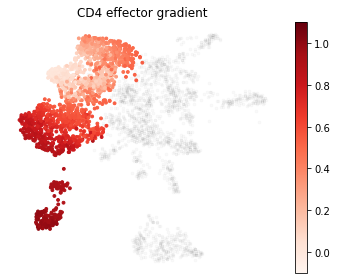

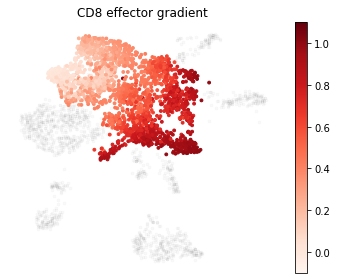

In [73]:
# Pseudotime: make it nicer later 
ds='facs'
adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
dic_title = {'dpt_cd4_qn': 'CD4 effector gradient', 
             'dpt_cd8_qn': 'CD8 effector gradient'}
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['dpt_cd4_qn', 'dpt_cd8_qn']])

for term in ['dpt_cd4_qn', 'dpt_cd8_qn']:    
    plt.figure(figsize=[5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    ind_select = df_plot[term]>0
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', alpha=0.025, s=8)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, term], cmap='Reds', vmax=1.1, vmin=-0.1, s=8)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(dic_title[term])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/%s.svg'%term)
    plt.show()
#     break

In [74]:
# Compute p-value
adata = dic_data_proc['facs'].copy()
df_stats = pd.DataFrame(columns=['DPT', 'TRAIT', 'P.scdrs', 'P.joint', 'T.scdrs', 'T.joint', 
                                 'var_explain.scdrs', 'var_explain.cluster', 'var_explain.joint'])
neg_list = ['naive_cd4', 'naive_cd8']

for dpt in ['dpt_cd4_qn', 'dpt_cd8_qn']:
    for score in ['facs', 'facs_tsig']:
        for trait in DIC_TRAIT_LIST[score]:
            if (dpt=='dpt_cd4_qn') & (trait in ['naive_cd8', 'memory_cd8', 'effector_cd8']):
                continue
            if (dpt=='dpt_cd8_qn') & (trait in ['naive_cd4', 'memory_cd4', 'effector_cd4', 'reg_cd4']):
                continue
            df_stats.loc['%s.%s'%(dpt,trait), ['DPT', 'TRAIT']] = [dpt, trait]
            df_reg = adata.obs[[dpt, 'leiden_fil']].copy()
            df_reg = df_reg.loc[df_reg[dpt]>0]
            df_reg['const'] = 1
            for cluster in set(df_reg['leiden_fil']):
                df_reg['C'+cluster] = 1*(df_reg['leiden_fil']==cluster)
            df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
            df_reg = df_reg.join(dic_ctrl_score[score][trait])
            
            # Regression using scdrs 
            cluster_list = [x for x in df_reg if x.startswith('C')]
            res = sm.OLS(df_reg[dpt],df_reg[['const', '%s.norm_score'%trait]]).fit()
            t_ = res.tvalues['%s.norm_score'%trait]
            var_explain_ = 1 - res.mse_resid/res.mse_total
            v_t_ = np.zeros(500)
            for i in range(500):
                res = sm.OLS(df_reg[dpt],df_reg[['const', 'ctrl_norm_score_%d'%i]]).fit()
                v_t_[i] = res.tvalues['ctrl_norm_score_%d'%i]
            if trait in neg_list:
                p_ = ((t_ >= v_t_).sum()+1) / 501
            else:
                p_ = ((t_ <= v_t_).sum()+1) / 501
            df_stats.loc['%s.%s'%(dpt,trait), ['T.scdrs', 'var_explain.scdrs', 'P.scdrs']] = [t_, var_explain_, p_]
                
            # Regression using cluster labels 
            cluster_list = [x for x in df_reg if x.startswith('C')]
            res = sm.OLS(df_reg[dpt],df_reg[cluster_list]).fit()
            var_explain_ = 1 - res.mse_resid/res.mse_total
            df_stats.loc['%s.%s'%(dpt,trait), ['var_explain.cluster']] = var_explain_
            
            # Regression using both cluster labels and scDTS score
            cluster_list = [x for x in df_reg if x.startswith('C')]
            res = sm.OLS(df_reg[dpt],df_reg[cluster_list+['%s.norm_score'%trait]]).fit()
            t_ = res.tvalues['%s.norm_score'%trait]
            var_explain_ = 1 - res.mse_resid/res.mse_total
            v_t_ = np.zeros(500)
            for i in range(500):
                res = sm.OLS(df_reg[dpt],df_reg[cluster_list+['ctrl_norm_score_%d'%i]]).fit()
                v_t_[i] = res.tvalues['ctrl_norm_score_%d'%i]
            if trait in neg_list:
                p_ = ((t_ >= v_t_).sum()+1) / 501
            else:
                p_ = ((t_ <= v_t_).sum()+1) / 501
            
            df_stats.loc['%s.%s'%(dpt,trait), ['T.joint', 'var_explain.joint', 'P.joint']] = [t_, var_explain_, p_]
            
def p_2_str(p_):
    if p_>0.05:
        return 'n.s.'
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
df_stats['P_STR'] = [p_2_str(x) for x in df_stats['P.scdrs']]
df_stats['P_STR_NUM'] = [p_2_str_num(x) for x in df_stats['P.scdrs']]
df_stats['P_STR.joint'] = [p_2_str(x) for x in df_stats['P.joint']]
df_stats['P_STR_NUM.joint'] = [p_2_str_num(x) for x in df_stats['P.joint']]

In [82]:
# Output table 
temp_df = df_stats.copy()
temp_df['Trait'] = [DF_TRAIT_INFO.loc[x, 'Code'] for x in temp_df['TRAIT']]
temp_df['Effector gradient'] = ['CD4' if x=='dpt_cd4_qn' else 'CD8' for x in temp_df['DPT']]
temp_df = temp_df[['Trait', 'Effector gradient', 'P.scdrs', 'P.joint', 
                   'var_explain.scdrs', 'var_explain.cluster', 'var_explain.joint']]
temp_df[['P.scdrs', 'P.joint', 'var_explain.scdrs', 'var_explain.cluster', 'var_explain.joint']] = \
    temp_df[['P.scdrs', 'P.joint', 'var_explain.scdrs', 'var_explain.cluster', 'var_explain.joint']].astype(np.float32)
print(temp_df.to_latex(index=False, column_format='ccccccc'))

\begin{tabular}{ccccccc}
\toprule
        Trait & Effector gradient &   P.scdrs &   P.joint &  var\_explain.scdrs &  var\_explain.cluster &  var\_explain.joint \\
\midrule
          IBD &               CD4 &  0.001996 &  0.003992 &           0.302747 &             0.837233 &           0.842420 \\
           CD &               CD4 &  0.001996 &  0.001996 &           0.229602 &             0.837233 &           0.843500 \\
           UC &               CD4 &  0.001996 &  0.037924 &           0.185947 &             0.837233 &           0.839240 \\
          AIT &               CD4 &  0.001996 &  0.009980 &           0.177228 &             0.837233 &           0.841155 \\
           HT &               CD4 &  0.013972 &  0.061876 &           0.093458 &             0.837233 &           0.838449 \\
       ECZEMA &               CD4 &  0.019960 &  0.287425 &           0.070122 &             0.837233 &           0.837292 \\
          ASM &               CD4 &  0.031936 &  0.285429 &           0.

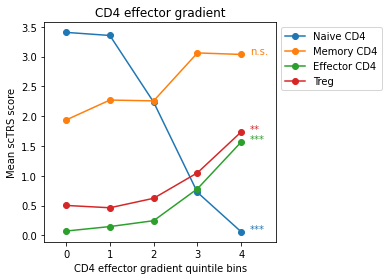

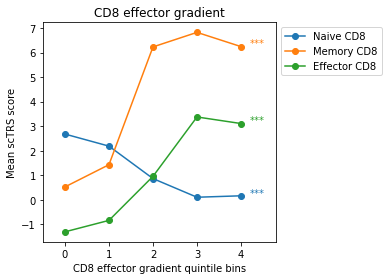

In [76]:
# T cell signatures
adata = dic_data_proc['facs'].copy()
plot_list = [['dpt_cd4_qn', ['naive_cd4', 'memory_cd4', 'effector_cd4', 'reg_cd4']],
             ['dpt_cd8_qn', ['naive_cd8', 'memory_cd8', 'effector_cd8']] ]

ds = 'facs_tsig'

for temp_list in plot_list:
    term,sig_list = temp_list
    df_plot = adata.obs[[term]].copy()
    df_plot = df_plot.loc[df_plot[term]>0]
    df_plot = df_plot.join(dic_score[ds].loc[adata.obs_names, ['%s.norm_score'%x for x in sig_list]])
    df_plot['bin'] = pd.qcut(df_plot[term], q=5, labels=False)
    
    plt.figure(figsize=[5.5,4])
    i_color = 0
    for sig in sig_list:
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%sig: np.mean})
        plt.plot(temp_df.index, temp_df['%s.norm_score'%sig], 'o-', label=DF_TRAIT_INFO.loc[sig, 'Code'],
                 color='C%d'%i_color)
        plt.text(4.2, temp_df['%s.norm_score'%sig][4], df_stats.loc['%s.%s'%(term,sig),'P_STR'],
                 color='C%d'%i_color)
        i_color+=1
    
    plt.xlim([-0.5,4.8])
    plt.legend(bbox_to_anchor=[1,1], loc='upper left')
    plt.xlabel('%s quintile bins'%dic_title[term])
    plt.ylabel('Mean scTRS score')
    plt.title(dic_title[term])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_tsig_corr.%s.svg'%term)
    plt.show()
    

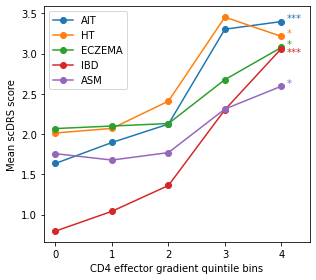

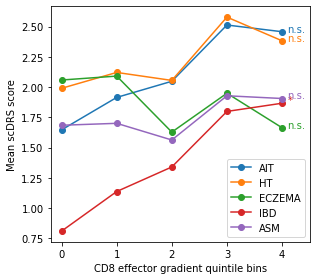

In [77]:
# Correlate with trait signal: reformat a bit 
adata = dic_data_proc['facs'].copy()
trait_list_plot = ['PASS_IBD_deLange2017', 'UKB_460K.disease_AID_ALL',
                   'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 
                   'UKB_460K.disease_ASTHMA_DIAGNOSED',
                   'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP']
ds = 'facs'

# Reorder traits 
dpt_q80 = np.quantile(adata.obs.loc[adata.obs['dpt_cd4']>0, 'dpt_cd4'], 0.8)
cell_list = adata.obs_names[adata.obs['dpt_cd4']>dpt_q80]
temp_df = pd.DataFrame(index=trait_list_plot,
                       data={'score': [dic_score[ds].loc[cell_list, '%s.norm_score'%x].mean()
                                       for x in trait_list_plot]})
temp_df.sort_values(by='score', ascending=False, inplace=True)
trait_list_plot = list(temp_df.index)

for term in ['dpt_cd4_qn', 'dpt_cd8_qn']:
    i_color = 0
    y_text = 5
    plt.figure(figsize=[4.5,4])
    for i_trait,trait in enumerate(trait_list_plot):

        df_plot = adata.obs[[term]].copy()
        df_plot = df_plot.loc[df_plot[term]>0]
        df_plot['bin'] = pd.qcut(df_plot[term], q=5, labels=False)
        df_plot = df_plot.join(dic_score[ds].loc[adata.obs_names, '%s.norm_score'%trait])

        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
        temp_df.columns = ['mean']

        plt.plot(temp_df.index, temp_df['mean'], 'o-', label=DF_TRAIT_INFO.loc[trait, 'Code'], 
                 color='C%d'%i_color)
        if term=='dpt_cd4_qn':
            y_text = min(y_text-0.1, temp_df['mean'][4])
        else:
            y_text = temp_df['mean'][4]
        plt.text(4.1, y_text, df_stats.loc['%s.%s'%(term,trait),'P_STR'], color='C%d'%i_color)
        i_color += 1
        
    plt.xlim([-0.2,4.5])
    plt.ylabel('Mean scDRS score')
    plt.xlabel('%s quintile bins'%dic_title[term])
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_trait_corr.%s.svg'%term)
    plt.show()

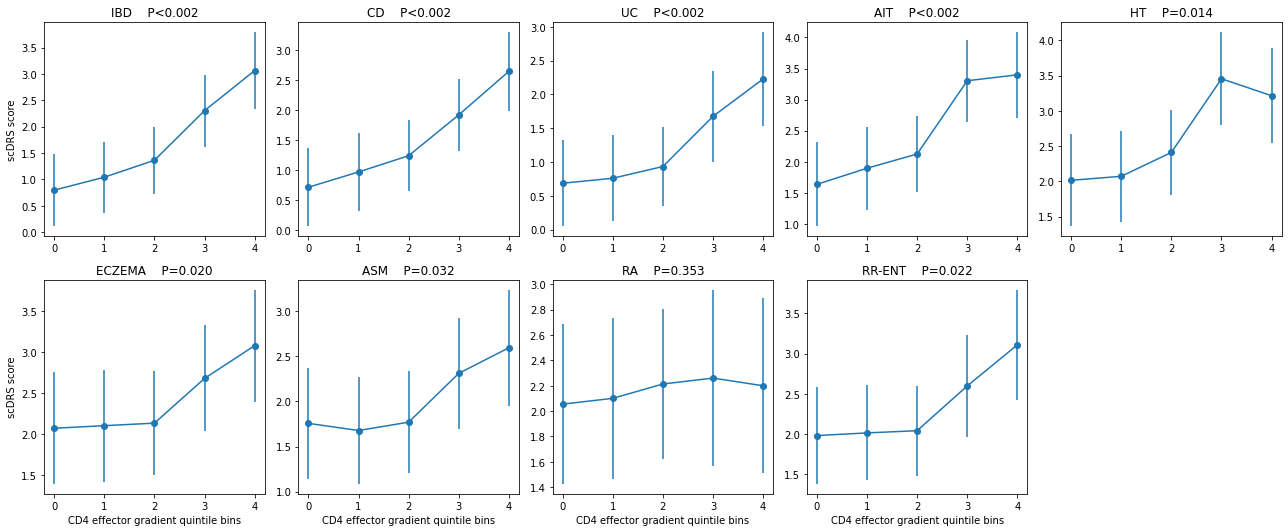

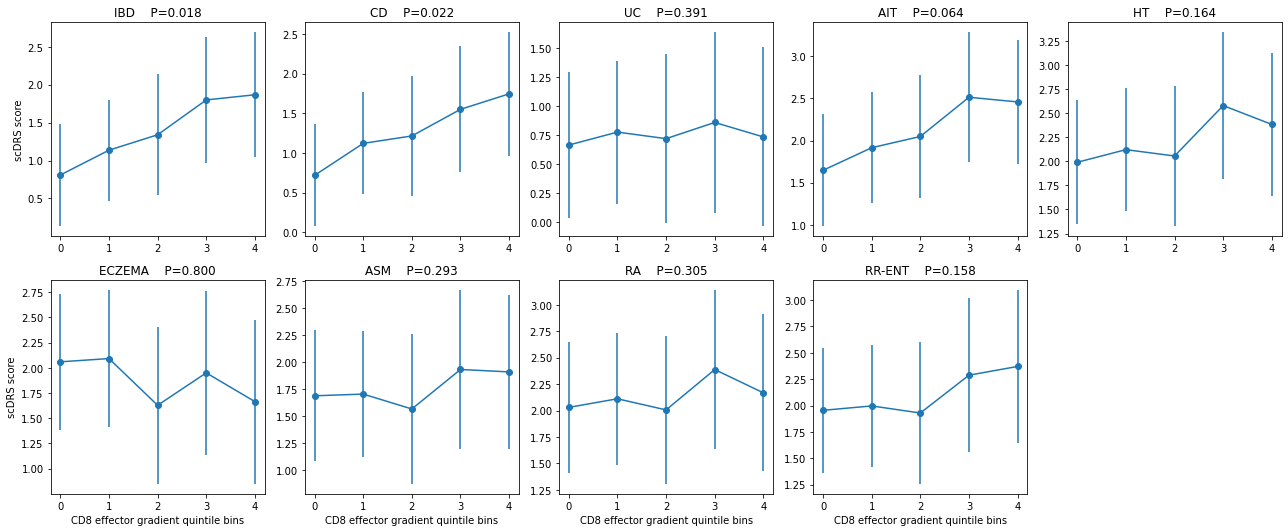

In [80]:
adata = dic_data_proc['facs'].copy()
ds = 'facs'

nrow,ncol =2,5
for term in ['dpt_cd4_qn', 'dpt_cd8_qn']:
    plt.figure(figsize=[18, 7.5])
    for i_trait,trait in enumerate(DIC_TRAIT_LIST['facs']):
        plt.subplot(nrow,ncol,i_trait+1)
        
        df_plot = adata.obs[[term]].copy()
        df_plot = df_plot.loc[df_plot[term]>0]
        df_plot['bin'] = pd.qcut(df_plot[term], q=5, labels=False)
        df_plot = df_plot.join(dic_score[ds].loc[adata.obs_names, '%s.norm_score'%trait])
        df_plot = df_plot.join(dic_ctrl_score[ds][trait])
        
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
        temp_df.columns = ['mean']
        temp_df_std = df_plot.groupby('bin').agg({'ctrl_norm_score_%d'%x: np.mean for x in range(500)}).std(axis=1)
        temp_df['std'] = temp_df_std.loc[temp_df.index].values
        
        plt.errorbar(temp_df.index, temp_df['mean'], yerr = temp_df['std']*1.96, fmt='-o', 
                     label=DF_TRAIT_INFO.loc[trait, 'Code'])
        plt.title(DF_TRAIT_INFO.loc[trait, 'Code']+'    ' + df_stats.loc['%s.%s'%(term,trait),'P_STR_NUM'])
        if i_trait>=ncol*(nrow-1):
            plt.xlabel('%s quintile bins'%dic_title[term])
        else:
            plt.xlabel('')
        if i_trait%ncol==0:
            plt.ylabel('scDRS score')
        else:
            plt.ylabel('')
        
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_trait_corr_all.%s.svg'%term)
    plt.show()

### Prioritize gene sets 

In [7]:
df_gs_gwas = pd.read_csv(GS_FILE, sep='\t', index_col=0)
df_hom = pd.read_csv(DATA_PATH + '/gene_annotation/mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
background_set = set(dic_data_raw['facs'].var_names) & set(dic_map.values())

In [8]:
# T cell specific genes 
temp_adata = dic_data_raw['facs'][:, list(background_set)].copy()
temp_adata.obs['tcell'] = 'nt'
temp_adata.obs.loc[dic_data_proc['facs'].obs_names, 'tcell'] = 't'
sc.tl.rank_genes_groups(temp_adata, groupby='tcell', groups=['t'])
df_t = sc.get.rank_genes_groups_df(temp_adata, 't')

... storing 'tissue_celltype' as categorical
... storing 'tcell' as categorical


In [9]:
# GWAS and scTRS gene sets 
dic_gs = {}
dic_corr_sctrs = {}

for trait in DIC_TRAIT_LIST['facs']:
    
    # GWAS gene set
    dic_gs['%s.gwas'%trait] = set([dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map])
    dic_gs['%s.gwas'%trait] = dic_gs['%s.gwas'%trait] & background_set
    
    # scTRS gene set
    temp_adata = dic_data_raw['facs'][dic_data_proc['facs'].obs_names, list(background_set)].copy()
    temp_adata.obs['sctrs'] = dic_score['facs'].loc[temp_adata.obs_names, '%s.norm_score'%trait]
    md.correlate_gene(temp_adata, trs_name='sctrs', corr_opt='pearson', cov_list=None)
    df_gene_corr = pd.DataFrame(index=temp_adata.var_names)
    df_gene_corr[trait] = temp_adata.var[['trs_corr']].copy()
    df_gene_corr.sort_values(by=trait, ascending=False, inplace=True)
    dic_gs['%s.sctrs'%trait] = set(df_gene_corr.index[:len(dic_gs['%s.gwas'%trait])])
    df_gene_corr['rank.sctrs'] = np.arange(df_gene_corr.shape[0])
    dic_corr_sctrs[trait] = df_gene_corr.copy()
    
    # tcell-specific genes 
    dic_gs['%s.tcell'%trait] = set(df_t['names'][:len(dic_gs['%s.gwas'%trait])])

In [10]:
# Gold standard gene sets 
dic_ref = {'PASS_IBD_deLange2017': 'Fang_NG_2019:UC.drug_target;Fang_NG_2019:CRO.drug_target',
           'PASS_CD_deLange2017': 'Fang_NG_2019:CRO.drug_target',
           'PASS_UC_deLange2017': 'Fang_NG_2019:UC.drug_target',            
#            'PASS_Multiple_sclerosis': 'Fang_NG_2019:MS.drug_target',
           'PASS_Rheumatoid_Arthritis': 'Fang_NG_2019:RA.drug_target',
           'UKB_460K.disease_AID_ALL': 'Freund_AJHG_2018:Immune_Dysregulation',
           'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED': 'Fang_NG_2019:ALG.drug_target',
           'UKB_460K.disease_ASTHMA_DIAGNOSED': 'Fang_NG_2019:ASM.drug_target',
           'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP': 'Freund_AJHG_2018:Immune_Dysregulation',
           'UKB_460K.disease_RESPIRATORY_ENT': 'Fang_NG_2019:ASM.drug_target'
            }
for trait in dic_ref: 
     dic_gs['%s.ref'%trait] = set()
        
for gs_ref in ['Fang_NG_2019', 'Freund_AJHG_2018']:
    df_gs_gold = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gold_standard_gs/%s.gs'%gs_ref,
                         sep='\t', index_col=0)
    for trait in dic_ref:
        for trait_ref in dic_ref[trait].split(';'):
            if gs_ref in trait_ref:
                trait_ref = trait_ref.replace('%s:'%gs_ref,'')
                dic_gs['%s.ref'%trait] = dic_gs['%s.ref'%trait] | \
                    set([dic_map[x] for x in df_gs_gold.loc[trait_ref, 'GENESET'].split(',') if x in dic_map])

In [11]:
# Compute stats 
dic_stats = {}
for res in ['gwas', 'sctrs', 'tcell']:
    dic_stats[res] = pd.DataFrame(columns=['GWAS', 'GS', 'overlap', 'odds_ratio', 'odds_ratio.ub',
                                           'odds_ratio.lb', 'pval', 'overlap_gene'], dtype=float)
    for trait in dic_ref:
        gs_set = dic_gs['%s.%s'%(trait, res)] & background_set
        gs_set_ref = dic_gs['%s.ref'%trait] & background_set
        pvalue,oddsratio,or_ub,or_lb = util.test_overlap(gs_set, gs_set_ref, background_set)

        dic_stats[res].loc[trait,'GWAS'] = len(gs_set)
        dic_stats[res].loc[trait,'GS'] = len(gs_set_ref)
        dic_stats[res].loc[trait,'overlap'] = len(gs_set & gs_set_ref)
        dic_stats[res].loc[trait,'odds_ratio'] = oddsratio
        dic_stats[res].loc[trait,'odds_ratio.ub'] = or_ub
        dic_stats[res].loc[trait,'odds_ratio.lb'] = or_lb
        dic_stats[res].loc[trait,'pval'] = pvalue
        dic_stats[res].loc[trait,'overlap_gene'] = ','.join(sorted(gs_set & gs_set_ref))

In [12]:
df_magma = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/MAGMA-v108/'
                       'MAGMA_v108_GENE_10_PSTAT.txt', sep='\t')
df_magma.index = [dic_map[x] if x in dic_map else 'non-map' for x in df_magma.index]
df_magma = df_magma.loc[df_magma.index!='non-map'].copy()

In [13]:
# Find examples
for trait in dic_ref:
    gs_sctrs = dic_gs['%s.sctrs'%(trait)] & background_set
    gs_gwas = dic_gs['%s.gwas'%(trait)] & background_set
    gs_set_ref = dic_gs['%s.ref'%trait] & background_set
    gs = (gs_sctrs-gs_gwas) & gs_set_ref
    
    temp_df = df_magma[[trait]].copy()
    temp_df.sort_values(trait, inplace=True)
    temp_df['rank.magma'] = np.arange(temp_df.shape[0])+1
    temp_df = temp_df.loc[[x in gs for x in temp_df.index]]
    temp_df = temp_df.join(dic_corr_sctrs[trait][['rank.sctrs']])
        
    print('# %s'%(trait))
    display(temp_df)
    
#     break

# PASS_IBD_deLange2017


,PASS_IBD_deLange2017,rank.magma,rank.sctrs
Alox5,0.003104,1053,196
Nr3c1,0.010835,1600,65
Il17a,0.012981,1716,508
Il13,0.021709,2091,463
Pparg,0.033196,2499,327
Itgb1,0.056027,3152,547
Pde4b,0.175680,5667,690
Il2rb,0.281630,7391,99
Igf1r,0.298780,7659,542
Itgb7,0.537340,10565,194


# PASS_CD_deLange2017


,PASS_CD_deLange2017,rank.magma,rank.sctrs
Pparg,0.084754,3522,695
Itgb1,0.127290,4403,759
Alox5,0.141530,4671,409
Itgb7,0.418250,8857,385
Nr3c1,0.665380,11689,127


# PASS_UC_deLange2017


,PASS_UC_deLange2017,rank.magma,rank.sctrs
Alox5,0.023803,1633,150
Pparg,0.124470,3998,353
Il13,0.667180,11605,448
Itgb7,0.850190,13538,44
Tnf,NaN,15104,695
Il2rg,NaN,15417,345


# PASS_Rheumatoid_Arthritis


,PASS_Rheumatoid_Arthritis,rank.magma,rank.sctrs
Jak3,0.15311,3488,217
Pde4b,0.15390,3509,283
Jak1,0.26156,5228,195
Fkbp1a,0.26952,5340,382
Itgb1,0.31111,5930,563
Itgb7,0.36108,6635,122
Nr3c1,0.51379,8704,233
Itga4,0.75577,11762,293
Tnfsf11,0.76734,11905,510
Cd4,0.83765,12799,290


# UKB_460K.disease_AID_ALL


,UKB_460K.disease_AID_ALL,rank.magma,rank.sctrs
Tnfaip3,0.011587,1090,40
Tbk1,0.014219,1197,683
Lmna,0.020054,1409,254
Prkar1a,0.030619,1767,100
Fermt3,0.041729,2066,644
Bcl10,0.045217,2141,654
Il10,0.046950,2192,274
Jak2,0.051735,2325,108
Hivep2,0.077695,2936,739
Cast,0.077931,2940,337


# UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED


,UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED,rank.magma,rank.sctrs
Vdr,0.00125,1096,697
Pde4b,0.03515,3096,681


# UKB_460K.disease_ASTHMA_DIAGNOSED


,UKB_460K.disease_ASTHMA_DIAGNOSED,rank.magma,rank.sctrs
Il17a,0.008592,1481,487
Nr3c1,0.035330,2682,46
Ltb4r1,0.316630,8007,325
Ifnar1,0.483910,10080,663
Vdr,0.628650,11603,565
Mapk14,0.855140,13766,442
Pde4b,0.879420,13964,305
Kcnn4,0.944260,14513,780


# UKB_460K.disease_HYPOTHYROIDISM_SELF_REP


,UKB_460K.disease_HYPOTHYROIDISM_SELF_REP,rank.magma,rank.sctrs
Cxcr4,0.001897,900,483
Relb,0.001966,914,219
Jak3,0.002095,922,256
Tnpo3,0.002139,928,819
Ifngr1,0.002293,949,208
Fermt3,0.002566,985,494
Tbk1,0.002834,1006,769
Copa,0.005028,1203,805
Bcl11b,0.005325,1233,443
Coro1a,0.008077,1428,396


# UKB_460K.disease_RESPIRATORY_ENT


,UKB_460K.disease_RESPIRATORY_ENT,rank.magma,rank.sctrs
Il17a,0.004304,1085,324
Nr3c1,0.021818,2017,51
Pde4b,0.239370,6624,241
Ltb4r1,0.782080,13022,100
Mapk14,0.855270,13721,660
Vdr,0.908840,14157,448


itcpt_=3.849


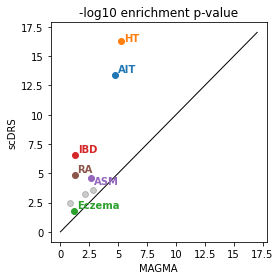

itcpt_=2.202


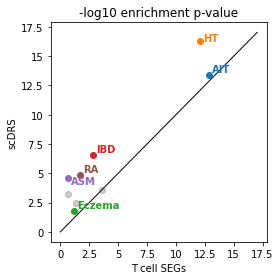

In [17]:
# Scatter plot for comparison 
dic_config = {'gwas': ['C0', 'MAGMA'], 
              'sctrs': ['C1', 'scDRS'], 
              'tcell': ['C2', 'T cell SEGs']}

dic_config_trait = {'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP': ['C1', 'd'], 
                    'UKB_460K.disease_AID_ALL': ['C0', '*'], 
                    'PASS_IBD_deLange2017': ['C3', 'v'], 
                    'PASS_Rheumatoid_Arthritis': ['C5', 's'],
                    'UKB_460K.disease_ASTHMA_DIAGNOSED': ['C4', 'H'],
                    'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED': ['C2', 'D']                   
                    }

df_plot = dic_stats['sctrs'][['GS']].copy()
for res in dic_config:
    df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
df_plot = df_plot.astype(dtype=float)
df_plot['loc'] = range(df_plot.shape[0])

for res_ref in ['gwas', 'tcell']:
    
    itcpt_ = (df_plot['sctrs.nlog10pval'] - df_plot['%s.nlog10pval'%res_ref]).mean()
    print('itcpt_=%0.3f'%itcpt_)

    plt.figure(figsize=[4,4])
    ind_select = (~df_plot.index.isin(dic_config_trait.keys()))
    plt.scatter(df_plot.loc[ind_select, '%s.nlog10pval'%res_ref], df_plot.loc[ind_select, 'sctrs.nlog10pval'],
                color='k', alpha=0.2, zorder=5)
    y_val = df_plot['sctrs.nlog10pval'].max()+1
    for trait in dic_config_trait:
        plt.scatter(df_plot.loc[trait, '%s.nlog10pval'%res_ref], df_plot.loc[trait, 'sctrs.nlog10pval'], 
                    color=dic_config_trait[trait][0], zorder=10)
        y_val = min(df_plot.loc[trait, 'sctrs.nlog10pval']+0.25, y_val-1)
        plt.text(df_plot.loc[trait, '%s.nlog10pval'%res_ref]+0.25, y_val, 
                 DF_TRAIT_INFO.loc[trait, 'Code'], color=dic_config_trait[trait][0], weight="bold", zorder=10)
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    max_ = max(xmax, ymax)
    plt.plot([0, max_], [0, max_], '-', color='k', alpha=1, zorder=0, linewidth=1)
    plt.xlabel(dic_config[res_ref][1])
    plt.ylabel(dic_config['sctrs'][1])
    plt.xticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5], [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5])
    plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5], [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5])
    plt.title('-log10 enrichment p-value')
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/comparison_gs_%s.svg'%res_ref)
    plt.show()
#     break

In [16]:
FIG_PATH

'/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_tcell'